This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns. The output is therefore multiclass.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning
* Section 3 - Data preprocessing
* Section 4 - Building an aspect classifier (Accommodation)
* Section 5 - Building an aspect classifier (Food)
* Section 6 - Building an aspect classifier (Attractions)

Dataset needed to run this notebook:

* combinedaspectcheck.xlsx

# Section 1: Import libraries and dataset

In [125]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE
import os
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [262]:
# Bring in manually annotated accommodation data from spreadsheet file
df_accom = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDACCOM",engine = "openpyxl")
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD", engine = "openpyxl")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT", engine = "openpyxl")

In [263]:
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

# Section 2: Data Cleaning

## Accommodation

In [264]:
df_accom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigId        2220 non-null   int64  
 1   Cleaned       2220 non-null   object 
 2   Noun Phrases  2220 non-null   object 
 3   Nouns         2220 non-null   object 
 4   Aspect        2220 non-null   object 
 5   Sentiment     2220 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 104.2+ KB


In [265]:
# Aspect value counts
df_accom["Aspect"].value_counts()

Food             350
Room             350
Staff            350
Hotel            349
Entertainment    348
Value            250
Location         215
location           5
entertainment      2
hotel              1
Name: Aspect, dtype: int64

In [266]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [267]:
df_accom["Aspect"].value_counts()

Food             350
Entertainment    350
Room             350
Hotel            350
Staff            350
Value            250
Location         220
Name: Aspect, dtype: int64

Mostly balanced categories, the two smaller categories represent those where all datapoints were used but there were just fewer overall.

## Food

In [268]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2100 non-null   int64  
 1   Cleaned       2100 non-null   object 
 2   Noun Phrases  2100 non-null   object 
 3   Nouns         2100 non-null   object 
 4   Sentiment     2100 non-null   float64
 5   Aspect        2100 non-null   object 
 6   Orig Aspect   2100 non-null   object 
 7   Column1       0 non-null      float64
dtypes: float64(2), int64(1), object(5)
memory usage: 131.4+ KB


In [269]:
# Aspect value counts
df_food["Aspect"].value_counts()

Visit Exp        350
Staff&Service    350
Meal Exp         350
Food Quality     350
Value            350
Menu Choice      350
Name: Aspect, dtype: int64

Balanced aspect categories

## Attractions

In [270]:
df_attract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       1650 non-null   int64  
 1   Cleaned       1650 non-null   object 
 2   Noun Phrases  1650 non-null   object 
 3   Nouns         1650 non-null   object 
 4   Sentiment     1650 non-null   float64
 5   Aspect        1650 non-null   object 
 6   OrigAspect    1648 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 90.4+ KB


In [271]:
df_attract["Aspect"].value_counts()

Amenities        300
Nature           300
Activities       300
VisitExp&Gen     250
Staff&Service    200
Value            150
History          150
Name: Aspect, dtype: int64

Unbalanced aspect categories due to not many datapoints available in the original dataset for some of the categories

# Section 3: Data preprocessing

## Define X and y

In [272]:
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [273]:
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

In [274]:
print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)

(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


## Train test split

In [275]:
# Train, validation, test split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True)
    return X_train,X_val,X_test,y_train,y_val,y_test

In [276]:
# Train, validation, test split
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [277]:
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


## Encode y and X

In [278]:
# Function to encode y values as one-hot encoded
def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [279]:
# Apply function
y_train_accom_e, y_val_accom_e, y_test_accom_e = bin(y_train_accom, y_val_accom, y_test_accom)
y_train_food_e, y_val_food_e, y_test_food_e = bin(y_train_food, y_val_food, y_test_food)
y_train_attract_e, y_val_attract_e, y_test_attract_e = bin(y_train_attract, y_val_attract, y_test_attract)

In [280]:
print(y_train_accom_e.shape, y_val_accom_e.shape, y_test_accom_e.shape)
print(y_train_food_e.shape, y_val_food_e.shape, y_test_food_e.shape)
print(y_train_attract_e.shape, y_val_attract_e.shape, y_test_attract_e.shape)

(1776, 7) (222, 7) (222, 7)
(1680, 6) (210, 6) (210, 6)
(1320, 7) (165, 7) (165, 7)


In [281]:
# Get maximum number of nouns to use in the 'maxlen' arguement
print(pd.DataFrame(X_train_accom)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_food)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_attract)["Nouns"].str.split().apply(len).max())

12
9
10


In [282]:
# Fit tokenizer on text and transform to vectors
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=15, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=15, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 15, padding = "post", truncating = "post", value = 0.0)
    
    return X_train_w, X_val_w, X_test_w

In [283]:
X_train_accom_w, X_val_accom_w, X_test_accom_w = tok(X_train_accom, X_val_accom, X_test_accom)
X_train_food_w, X_val_food_w, X_test_food_w = tok(X_train_food, X_val_food, X_test_food)
X_train_attract_w, X_val_attract_w, X_test_attract_w = tok(X_train_attract, X_val_attract, X_test_attract)

In [284]:
print(X_train_accom_w.shape,y_train_accom_e.shape)
print(X_train_food_w.shape, y_train_food_e.shape)
print(X_train_attract_w.shape, y_train_attract_e.shape)

(1776, 15) (1776, 7)
(1680, 15) (1680, 6)
(1320, 15) (1320, 7)


# Section 4: Building accommodation aspect classifier

## Define functions used for each model

In [285]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

In [286]:
# The model will use earlystopping if the valuation loss doesn't decrease after 5 epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir,patience):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = patience),modelcheckpoint]
    return callbacks

In [287]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class):
    classification = classification_report(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)

In [288]:
# Weight adjustments if required
def weight(y_train):
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    return class_weights

In [289]:
# Run function
cw_accom = weight(y_accom)
cw_food = weight(y_food)
cw_attract = weight(y_attract)

In [290]:
# Print weights
print(cw_accom)
print(cw_food)
print(cw_attract)

[0.90612245 0.90612245 0.90612245 1.44155844 0.90612245 0.90612245
 1.26857143]
[1. 1. 1. 1. 1. 1.]
[0.78571429 0.78571429 1.57142857 0.78571429 1.17857143 1.57142857
 0.94285714]


## Build Accommodation Model

In [291]:
# Set parameters
input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_accom[0],1:cw_accom[1],2:cw_accom[2],3:cw_accom[3],4:cw_accom[4],5:cw_accom[5],6:cw_accom[6]}

In [292]:
# Define model - best performing sentiment model as a starting point
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_shape=(1600,)))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(7, activation='softmax'))

In [293]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 15, 16)            96000     
_________________________________________________________________
flatten_7 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
________________________________________________

In [294]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/AccomAspectModels')
callbacks = call(output_dir,5)

In [295]:
# Model using keras embeddings
history = model.fit(X_train_accom_w,y_train_accom_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_accom_w, y_val_accom_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
111/111 - 0s - loss: 1.3958 - accuracy: 0.4820 - val_loss: 0.5898 - val_accuracy: 0.8694
Epoch 2/50
111/111 - 0s - loss: 0.3416 - accuracy: 0.9003 - val_loss: 0.3720 - val_accuracy: 0.8919
Epoch 3/50
111/111 - 0s - loss: 0.1232 - accuracy: 0.9668 - val_loss: 0.1901 - val_accuracy: 0.9505
Epoch 4/50
111/111 - 0s - loss: 0.0501 - accuracy: 0.9870 - val_loss: 0.2107 - val_accuracy: 0.9550
Epoch 5/50
111/111 - 0s - loss: 0.0274 - accuracy: 0.9932 - val_loss: 0.1963 - val_accuracy: 0.9459
Epoch 6/50
111/111 - 0s - loss: 0.0198 - accuracy: 0.9955 - val_loss: 0.2056 - val_accuracy: 0.9414
Epoch 7/50
111/111 - 0s - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.1694 - val_accuracy: 0.9459
Epoch 8/50
111/111 - 0s - loss: 0.0173 - accuracy: 0.9955 - val_loss: 0.1900 - val_accuracy: 0.9459
Epoch 9/50
111/111 - 0s - loss: 0.0127 - accuracy: 0.9977 - val_loss: 0.2078 - val_accuracy: 0.9550
Epoch 10/50
111/111 - 0s - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.2315 - val_accuracy: 0.9459

## Evaluate model

In [296]:
print(model.evaluate(X_train_accom_w, y_train_accom_e))
print(model.evaluate(X_val_accom_w, y_val_accom_e))

56/56 [==============================] - 0s 427us/step - loss: 0.0068 - accuracy: 0.9989
[0.006796261761337519, 0.9988738894462585]
7/7 [==============================] - 0s 570us/step - loss: 0.1955 - accuracy: 0.9550
[0.19550715386867523, 0.954954981803894]


The model is overfitting as shown with the training accuracy of 1 and the validation accuracy falling short of this.

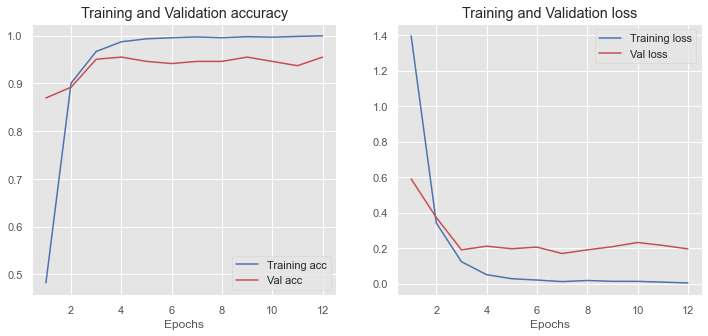

In [297]:
plot_history(history)

In [298]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.04.hdf5")

In [299]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob = model.predict(X_val_accom_w)
y_pred_class = np.argmax(model.predict(X_val_accom_w), axis=-1)
y_val_accom_integer = np.argmax(y_val_accom_e, axis=1)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       1.00      0.94      0.97        35
           2       1.00      0.97      0.99        35
           3       0.95      0.95      0.95        22
           4       0.85      0.97      0.91        35
           5       0.95      1.00      0.97        35
           6       1.00      0.96      0.98        25

    accuracy                           0.95       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.95      0.96       222



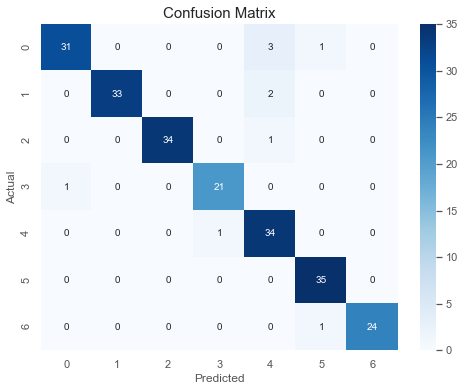

In [300]:
class_conf(y_val_accom_integer,y_pred_class)

In [301]:
# Create dataframe with y pred probabilities, classes and y actual
accom_pred = pd.DataFrame(list(zip(y_val_accom_integer, y_val_accom,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
accom_pred.sample(3)

,Actual Class,Actual Aspect,Predicted Class
172,1,Food,1
130,5,Staff,5
164,0,Entertainment,0


In [302]:
# Items not classified correctly
accom_wrong = accom_pred[accom_pred["Actual Class"]!= accom_pred["Predicted Class"]]
accom_wrong.head(10)

,Actual Class,Actual Aspect,Predicted Class
63,1,Food,4
72,4,Room,3
76,0,Entertainment,4
90,2,Hotel,4
91,0,Entertainment,5
120,0,Entertainment,4
145,6,Value,5
147,0,Entertainment,4
165,1,Food,4
198,3,Location,0


In [303]:
print("The model predicted:", accom_wrong.shape[0],"aspects wrong from a total of:",accom_pred.shape[0],"predictions")

The model predicted: 10 aspects wrong from a total of: 222 predictions


In [304]:
# Get the aspects and aspect classes
accom_pred.groupby(["Actual Class","Actual Aspect"],as_index = False).count()

,Actual Class,Actual Aspect,Predicted Class
0,0,Entertainment,35
1,1,Food,35
2,2,Hotel,35
3,3,Location,22
4,4,Room,35
5,5,Staff,35
6,6,Value,25


In [308]:
X_val_accom.iloc[76]

'need'

In [309]:
X_val_accom.iloc[91]

'thanks becca stage'

In [310]:
X_val_accom.iloc[120]

'grandson'

General comments:

* the model is overfitting
* the model seems to misclassifying some aspects - these topics may be fuzzy fitting into more than one aspect
* more training data might help the model

# Section 5: Building a food aspect classifier

## Build model

In [311]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_food[0],1:cw_food[1],2:cw_food[2],3:cw_food[3],4:cw_food[4],5:cw_food[5]}

In [312]:
# Define model - best performing sentiment model as a starting point
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(512, activation='relu', input_shape=(1600,)))
model2.add(Dense(256,activation = 'relu'))
model2.add(Dense(128,activation = 'relu'))
model2.add(Dense(6, activation='softmax'))

In [313]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 15, 16)            96000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 6)                 774       
Total params: 384,390
Trainable params: 384,390
Non-trainable params: 0
________________________________________________

In [314]:
output_dir = out('model_output/FoodAspectModels1')
callbacks = call(output_dir,5)

In [315]:
# Model using keras embeddings
history2 = model2.fit(X_train_food_w,y_train_food_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_food_w, y_val_food_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
105/105 - 0s - loss: 1.0961 - accuracy: 0.6048 - val_loss: 0.2803 - val_accuracy: 0.9095
Epoch 2/50
105/105 - 0s - loss: 0.1771 - accuracy: 0.9476 - val_loss: 0.1949 - val_accuracy: 0.9381
Epoch 3/50
105/105 - 0s - loss: 0.0754 - accuracy: 0.9780 - val_loss: 0.1537 - val_accuracy: 0.9619
Epoch 4/50
105/105 - 0s - loss: 0.0385 - accuracy: 0.9905 - val_loss: 0.1731 - val_accuracy: 0.9524
Epoch 5/50
105/105 - 0s - loss: 0.0231 - accuracy: 0.9940 - val_loss: 0.2248 - val_accuracy: 0.9524
Epoch 6/50
105/105 - 0s - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.2234 - val_accuracy: 0.9571
Epoch 7/50
105/105 - 0s - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.2030 - val_accuracy: 0.9524
Epoch 8/50
105/105 - 0s - loss: 0.0104 - accuracy: 0.9958 - val_loss: 0.2822 - val_accuracy: 0.9238


In [316]:
print(model2.evaluate(X_train_food_w, y_train_food_e))
print(model2.evaluate(X_val_food_w, y_val_food_e))

53/53 [==============================] - 0s 428us/step - loss: 0.0558 - accuracy: 0.9804
[0.055776599794626236, 0.9803571701049805]
7/7 [==============================] - 0s 427us/step - loss: 0.2822 - accuracy: 0.9238
[0.28219830989837646, 0.9238095283508301]


Again the training accuracy is above the validation accuracy but not as far adrift as the previous model.

## Evaluate model

In [317]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.03.hdf5")

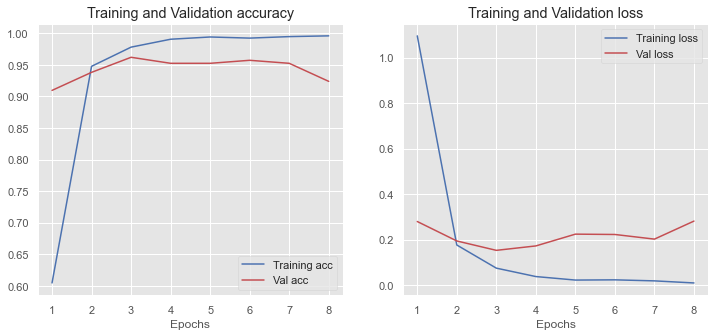

In [318]:
plot_history(history2)

In [319]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob2 = model2.predict(X_val_food_w)
y_pred_class2 = np.argmax(model2.predict(X_val_food_w), axis=-1)
y_val_food_integer = np.argmax(y_val_food_e, axis=1)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       0.91      0.91      0.91        35
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        35
           4       1.00      0.97      0.99        35
           5       0.94      0.91      0.93        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



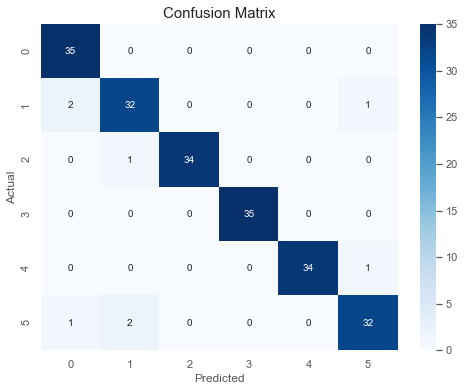

In [320]:
class_conf(y_val_food_integer,y_pred_class2)

In [321]:
# Create dataframe with y pred probabilities, classes and y actual
food_pred = pd.DataFrame(list(zip(y_val_food_integer, y_val_food,y_pred_class2)), columns=["Actual Class", "Actual Aspect","Predicted Class"])
food_pred.head(10)

,Actual Class,Actual Aspect,Predicted Class
0,5,Visit Exp,5
1,3,Staff&Service,3
2,3,Staff&Service,3
3,3,Staff&Service,3
4,2,Menu Choice,2
5,1,Meal Exp,1
6,2,Menu Choice,2
7,4,Value,4
8,2,Menu Choice,2
9,4,Value,5


In [322]:
# Items not classified correctly
food_wrong = food_pred[food_pred["Actual Class"]!= food_pred["Predicted Class"]]
food_wrong.head(10)

,Actual Class,Actual Aspect,Predicted Class
9,4,Value,5
59,5,Visit Exp,1
70,1,Meal Exp,0
71,5,Visit Exp,1
79,1,Meal Exp,5
142,5,Visit Exp,0
168,2,Menu Choice,1
195,1,Meal Exp,0


In [323]:
# Get the aspects and aspect classes as reference table
food_pred.groupby(["Actual Class","Actual Aspect"],as_index = False).count()

,Actual Class,Actual Aspect,Predicted Class
0,0,Food Quality,35
1,1,Meal Exp,35
2,2,Menu Choice,35
3,3,Staff&Service,35
4,4,Value,35
5,5,Visit Exp,35


In [324]:
print("The model predicted:", food_wrong.shape[0],"aspects wrong from a total of:",food_pred.shape[0],"predictions")

The model predicted: 8 aspects wrong from a total of: 210 predictions


## Analysis of the food model results

There are some labelling issues but the model does have some clear problems with misclassifying meal and visit experiences which are close in meaning. Therefore, combining the two categories may simplify the model a little.

## Recategorise the aspects and re-run the model

In [325]:
# Combine the two categories
df_food["Aspect"] = df_food["Aspect"].replace("Visit Exp","Meal Exp")
df_food.Aspect.value_counts()

Meal Exp         700
Staff&Service    350
Food Quality     350
Value            350
Menu Choice      350
Name: Aspect, dtype: int64

In [326]:
# Take random 350 items from this combined category
meal = df_food[df_food["Aspect"] == "Meal Exp"]
meal = meal.sample(n = 350)
meal.shape

(350, 8)

In [327]:
# Create new dataframe dropping the two aspect categories no longer wanted and then concat with the new combined category
aspect_list = ["Menu Choice","Food Quality","Staff&Service","Value"]
df_food_new = df_food[df_food["Aspect"].isin(aspect_list)]
df_food_new = pd.concat([df_food_new,meal],axis = 0,ignore_index = True)

In [328]:
# Define X and y, train, test, split and encode X and y variables
X_food_new,y_food_new = XY(df_food_new)
X_train_food2,X_val_food2,X_test_food2,y_train_food2,y_val_food2,y_test_food2 = train_test(X_food_new,y_food_new)
y_train_food_e2, y_val_food_e2, y_test_food_e2 = bin(y_train_food2, y_val_food2, y_test_food2)
X_train_food_w2, X_val_food_w2, X_test_food_w2 = tok(X_train_food2, X_val_food2, X_test_food2)

In [329]:
# Define model - set output to only 5 categories

model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(512, activation='relu', input_shape=(1600,)))
model3.add(Dense(256,activation = 'relu'))
model3.add(Dense(128,activation = 'relu'))
model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 15, 16)            96000     
_________________________________________________________________
flatten_9 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 645       
Total params: 384,261
Trainable params: 384,261
Non-trainable params: 0
________________________________________________

In [330]:
# Set output directory and callbacks
output_dir = out('model_output/FoodAspectModels2')
callbacks = call(output_dir,5)

In [331]:
# Run model

history3 = model3.fit(X_train_food_w2,y_train_food_e2,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_food_w2, y_val_food_e2),
                    batch_size=batch_size,
                     )

Epoch 1/50
88/88 - 0s - loss: 0.9639 - accuracy: 0.6443 - val_loss: 0.2941 - val_accuracy: 0.8971
Epoch 2/50
88/88 - 0s - loss: 0.1733 - accuracy: 0.9564 - val_loss: 0.1141 - val_accuracy: 0.9714
Epoch 3/50
88/88 - 0s - loss: 0.0754 - accuracy: 0.9814 - val_loss: 0.1003 - val_accuracy: 0.9657
Epoch 4/50
88/88 - 0s - loss: 0.0368 - accuracy: 0.9943 - val_loss: 0.0904 - val_accuracy: 0.9714
Epoch 5/50
88/88 - 0s - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.1045 - val_accuracy: 0.9600
Epoch 6/50
88/88 - 0s - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.1139 - val_accuracy: 0.9657
Epoch 7/50
88/88 - 0s - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.1284 - val_accuracy: 0.9714
Epoch 8/50
88/88 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9657
Epoch 9/50
88/88 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1157 - val_accuracy: 0.9714


In [332]:
print(model3.evaluate(X_train_food_w2, y_train_food_e2))
print(model3.evaluate(X_val_food_w2, y_val_food_e2))

44/44 [==============================] - 0s 431us/step - loss: 5.0312e-04 - accuracy: 1.0000
[0.0005031158798374236, 1.0]
6/6 [==============================] - 0s 665us/step - loss: 0.1157 - accuracy: 0.9714
[0.11570765823125839, 0.9714285731315613]


In [333]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.02.hdf5")

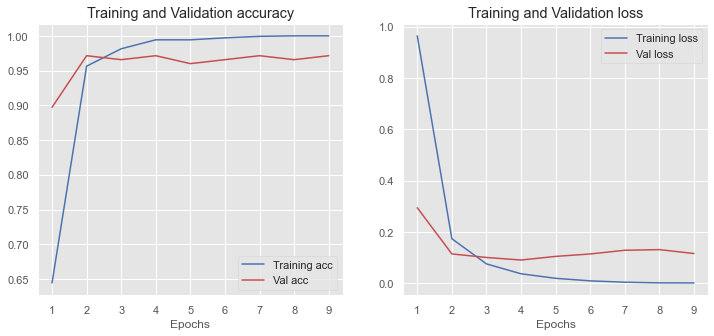

In [334]:
plot_history(history3)

In [335]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob3 = model3.predict(X_val_food_w2)
y_pred_class3 = np.argmax(model3.predict(X_val_food_w2), axis=-1)
y_val_food_integer = np.argmax(y_val_food_e2, axis=1)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.89      0.97      0.93        35
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        35

    accuracy                           0.97       175
   macro avg       0.97      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175



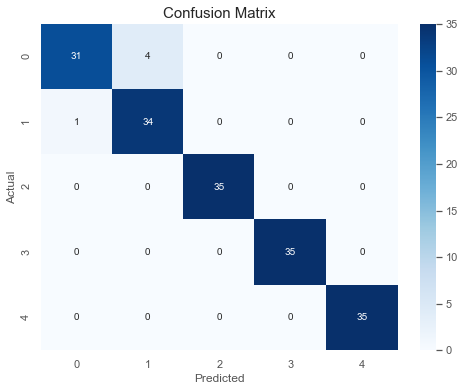

In [336]:
class_conf(y_val_food_integer,y_pred_class3)

In [337]:
# Create dataframe with y pred probabilities, classes and y actual
food_pred2 = pd.DataFrame(list(zip(y_val_food_integer,y_val_food2, y_pred_class3 )), columns=["Actual Class", "Actual Aspect","Predicted Class"])
food_pred2.head(10)

,Actual Class,Actual Aspect,Predicted Class
0,2,Menu Choice,2
1,0,Food Quality,0
2,2,Menu Choice,2
3,3,Staff&Service,3
4,3,Staff&Service,3
5,4,Value,4
6,1,Meal Exp,1
7,4,Value,4
8,0,Food Quality,1
9,0,Food Quality,0


In [338]:
# Items not classified correctly
food_wrong2 = food_pred2[food_pred2["Actual Class"]!= food_pred2["Predicted Class"]]
food_wrong2

,Actual Class,Actual Aspect,Predicted Class
8,0,Food Quality,1
29,0,Food Quality,1
140,1,Meal Exp,0
150,0,Food Quality,1
174,0,Food Quality,1


In [342]:
print("The model predicted:", food_wrong2.shape[0],"aspects wrong from a total of:",food_pred2.shape[0],"predictions")

The model predicted: 5 aspects wrong from a total of: 175 predictions


General comments:

* Food reviews tend to be shorter, mention multiple topics in the one noun phrase. The labelling of the model took the first mentioned aspect in a noun phrase as the one that it was labelled as, for example if a row had nouns "Food", "Service", then the word "Food" is the one that is used to label the data. This means that some aspects are being missed. A multi-label model might actually perform better.

* Where reviews lack punctuation, those rows cannot be split into sentences, then noun phrases properly. This results in many nouns for a datapoint which compounds the problem above and confuses the model. One measure might be to exclude those datapoints where the number of nouns is more than say 3 or 4 but there would still be cases where at least two aspects are mentioned in a single noun-phrase.


# Section 6: Building an attractions model

## Build a model

In [343]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

In [344]:
print(class_weights)

{0: 0.7857142857142857, 1: 0.7857142857142857, 2: 1.5714285714285714, 3: 0.7857142857142857, 4: 1.1785714285714286, 5: 1.5714285714285714, 6: 0.9428571428571428}


In [345]:
# Define model - best performing sentiment model as a starting point
model4 = Sequential()
model4.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model4.add(Flatten())
model4.add(Dense(512, activation='relu', input_shape=(1600,)))
model4.add(Dense(256,activation = 'relu'))
model4.add(Dense(128,activation = 'relu'))
model4.add(Dense(7, activation='softmax'))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_10 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
_______________________________________________

In [346]:
output_dir = out('model_output/AttractAspectModels4')
callbacks = call(output_dir,5)

In [347]:
# Model using keras embeddings
history4 = model4.fit(X_train_attract_w,y_train_attract_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_attract_w, y_val_attract_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
83/83 - 0s - loss: 1.8248 - accuracy: 0.2098 - val_loss: 1.4588 - val_accuracy: 0.3212
Epoch 2/50
83/83 - 0s - loss: 1.0739 - accuracy: 0.5621 - val_loss: 0.7594 - val_accuracy: 0.7697
Epoch 3/50
83/83 - 0s - loss: 0.5020 - accuracy: 0.8424 - val_loss: 0.5665 - val_accuracy: 0.8182
Epoch 4/50
83/83 - 0s - loss: 0.2073 - accuracy: 0.9402 - val_loss: 0.5532 - val_accuracy: 0.8727
Epoch 5/50
83/83 - 0s - loss: 0.1022 - accuracy: 0.9720 - val_loss: 0.6419 - val_accuracy: 0.8424
Epoch 6/50
83/83 - 0s - loss: 0.0584 - accuracy: 0.9826 - val_loss: 0.7492 - val_accuracy: 0.8727
Epoch 7/50
83/83 - 0s - loss: 0.0495 - accuracy: 0.9848 - val_loss: 0.6558 - val_accuracy: 0.8667
Epoch 8/50
83/83 - 0s - loss: 0.0217 - accuracy: 0.9947 - val_loss: 0.6593 - val_accuracy: 0.8606
Epoch 9/50
83/83 - 0s - loss: 0.0275 - accuracy: 0.9932 - val_loss: 0.6466 - val_accuracy: 0.8667


In [348]:
print(model4.evaluate(X_train_attract_w, y_train_attract_e))
print(model4.evaluate(X_val_attract_w, y_val_attract_e))

42/42 [==============================] - 0s 475us/step - loss: 0.0157 - accuracy: 0.9962
[0.01573372632265091, 0.9962121248245239]
6/6 [==============================] - 0s 665us/step - loss: 0.6466 - accuracy: 0.8667
[0.6465871930122375, 0.8666666746139526]


In [349]:
# Load model weights from epoch with best validation accuracy
model4.load_weights(output_dir+"/weights.07.hdf5")

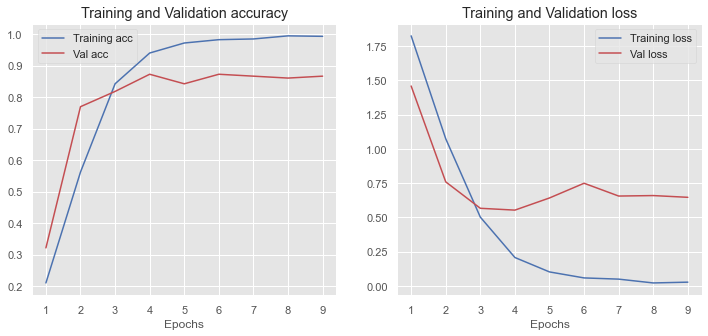

In [350]:
plot_history(history4)

In [351]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob4 = model4.predict(X_val_attract_w)
y_pred_class4 = np.argmax(model4.predict(X_val_attract_w), axis=-1)
y_val_attract_integer = np.argmax(y_val_attract_e, axis=1)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.89      0.80      0.84        30
           2       0.92      0.80      0.86        15
           3       1.00      0.80      0.89        30
           4       0.86      0.95      0.90        20
           5       0.93      0.93      0.93        15
           6       0.61      0.88      0.72        25

    accuracy                           0.87       165
   macro avg       0.89      0.87      0.87       165
weighted avg       0.89      0.87      0.87       165



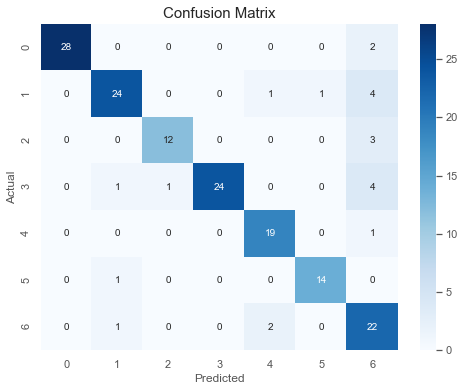

In [352]:
class_conf(y_val_attract_integer,y_pred_class4)

In [353]:
# Create dataframe with y pred probabilities, classes and y actual
attract_pred = pd.DataFrame(list(zip(y_val_attract_integer, y_val_attract,y_pred_class4)), columns=["Actual Class","Actual Aspect", "Predicted Class"])
attract_pred.head(10)

,Actual Class,Actual Aspect,Predicted Class
0,2,History,2
1,5,Value,5
2,0,Activities,0
3,2,History,2
4,3,Nature,3
5,6,VisitExp&Gen,6
6,5,Value,5
7,3,Nature,3
8,3,Nature,1
9,6,VisitExp&Gen,6


In [358]:
# Items not classified correctly
attract_wrong = attract_pred[attract_pred["Actual Class"]!= attract_pred["Predicted Class"]]
attract_wrong

,Actual Class,Actual Aspect,Predicted Class
8,3,Nature,1
16,0,Activities,6
33,4,Staff&Service,6
49,2,History,6
53,1,Amenities,6
54,3,Nature,2
57,3,Nature,6
71,6,VisitExp&Gen,1
78,3,Nature,6
79,3,Nature,6


In [359]:
print("The model predicted:", attract_wrong.shape[0],"aspects wrong from a total of:",attract_pred.shape[0],"predictions")

The model predicted: 22 aspects wrong from a total of: 165 predictions


## Analysis of results

* Model does not perform as well as the previous models for accommodation and food. The model is overfitting and does not generalise to new data well. The attractions category is a difficult one to classify based on the nouns as features since many of the words are vague and the aspects are in some cases a bit 'fuzzy' (the nouns could be classed to more than one category based on interpretation). This is particularly the case where is just one word noun in the training features. Also there are very few datapoints in some of the aspect classes. The class weights in the model are balanced but more training data is likely to help the model perform better. Labelling is time consuming and difficult so tactics include:

* Creating synthetic datapoints for the classes with less datapoints
* Augmenting the training data using techniques such as swapping, deleting or adding words

# Section 7: Synthetic Minority Oversampling

In [360]:
print(len(X_train_attract_w))
print(len(y_train_attract))

1320
1320


In [361]:
# Label encode the y data to classes
le = preprocessing.LabelEncoder()
y_train_attract_labelled = le.fit_transform(y_train_attract)
y_val_attract_labelled = le.transform(y_val_attract)
y_test_attract_labelled = le.transform(y_test_attract)

In [362]:
# Creates samples in all minority classes to match the number in the majority class
oversample = SMOTE()
X_train_attract_over, y_train_attract_over = oversample.fit_resample(X_train_attract_w, y_train_attract_labelled)
y_train_attract_over

array([0, 6, 3, ..., 6, 6, 6])

In [363]:
# New lengths of training sets
print(len(X_train_attract_over))
print(len(y_train_attract_over))

1680
1680


In [364]:
# Check class distribution
pd.Series(y_train_attract_over).value_counts()

0    240
1    240
2    240
3    240
4    240
5    240
6    240
dtype: int64

In [365]:
# One-hot encoded the oversample y data
y_train_e2, y_val_e2, y_test_e2 = bin(y_train_attract_over, y_val_attract_labelled, y_test_attract_labelled)

In [366]:
len(X_train_attract_over)

1680

In [367]:
# Model using keras embeddings using the previous model 4 but no class weights as the classes are balanced
history5 = model4.fit(X_train_attract_over,y_train_e2,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_attract_w, y_val_e2),
                    batch_size=batch_size
                     )

Epoch 1/50
105/105 - 0s - loss: 0.5674 - accuracy: 0.8863 - val_loss: 0.5838 - val_accuracy: 0.8545
Epoch 2/50
105/105 - 0s - loss: 0.3135 - accuracy: 0.9214 - val_loss: 0.6621 - val_accuracy: 0.8424
Epoch 3/50
105/105 - 0s - loss: 0.2203 - accuracy: 0.9381 - val_loss: 0.7436 - val_accuracy: 0.8545
Epoch 4/50
105/105 - 0s - loss: 0.1744 - accuracy: 0.9524 - val_loss: 0.8218 - val_accuracy: 0.8364
Epoch 5/50
105/105 - 0s - loss: 0.1358 - accuracy: 0.9637 - val_loss: 0.8745 - val_accuracy: 0.8364
Epoch 6/50
105/105 - 0s - loss: 0.1210 - accuracy: 0.9667 - val_loss: 0.8027 - val_accuracy: 0.8182


In [368]:
print(model4.evaluate(X_train_attract_over, y_train_e2))
print(model4.evaluate(X_val_attract_w, y_val_e2))

53/53 [==============================] - 0s 452us/step - loss: 0.0915 - accuracy: 0.9738
[0.09151766449213028, 0.973809540271759]
6/6 [==============================] - 0s 665us/step - loss: 0.8027 - accuracy: 0.8182
[0.802695095539093, 0.8181818127632141]


The model has not improved. SMOTE can not perform as well with text data, as it is oversampling on high-dimensional word embeddings and the resultant embeddings may not make much sense.

# Section 8: Data Augmentation

In [369]:
# Look at value counts of classes in the attractions category
pd.Series(y_attract.value_counts())

Amenities        300
Nature           300
Activities       300
VisitExp&Gen     250
Staff&Service    200
Value            150
History          150
Name: Aspect, dtype: int64

In [370]:
# Concat and shuffle the data
attract_eda = pd.concat([X_attract,y_attract],axis = 1)
attract_eda = attract_eda.sample(frac=1)
attract_eda.head()

,Nouns,Aspect
682,cup tea,Amenities
1045,staff member,Staff&Service
684,wine good,Amenities
767,hand towel dispenser,Amenities
1330,auditorium,Activities


In [371]:
attract_eda.shape

(1650, 2)

In [372]:
# Get number of words in each row, split dataframes into those with more than 1 word and those with 1
attract_eda["Count"] = attract_eda["Nouns"].apply(lambda x: len(x.split()))
attract_eda["Count"].value_counts()

1     781
2     497
3     222
4      89
5      33
6      17
7       8
8       1
9       1
10      1
Name: Count, dtype: int64

Most lines with more than one word have two words, this will inform the augmentation process

In [373]:
attract_eda.shape

(1650, 3)

## Random insertion

In [381]:
from textaugment import EDA
t = EDA()

In [382]:
# Take sample
test = attract_eda["Nouns"].iloc[10]
test

'room'

In [383]:
# Random insertion two words
t.random_insertion(test, n = 2)

'way way room'

In [384]:
insertion = pd.DataFrame(attract_eda["Nouns"].apply(lambda x: t.random_insertion(x)))
insertion = pd.concat([insertion,attract_eda.Aspect],axis = 1)
insertion = insertion.append(attract_eda)
insertion.shape

(3300, 3)

## Synonym replacement

In [385]:
# Run synonym replacement
t.synonym_replacement(test,n = 1)

'board'

In [386]:
# Apply to the whole dataframe and conat to original df
replaced = pd.DataFrame(insertion["Nouns"].apply(lambda x: t.synonym_replacement(x)))
replaced = pd.concat([replaced,insertion.Aspect],axis = 1)
replaced = replaced.append(insertion)
replaced.shape

(6600, 3)

## Random swap

Swap out a specified number of words randomly

In [390]:
# Take sample
test = attract_eda["Nouns"].iloc[8]
test

'hide'

In [391]:
t.random_swap(test, n = 1)

'hide'

In [392]:
swapped = pd.DataFrame(replaced["Nouns"].apply(lambda x: t.random_swap(x,n  = 1)))
swapped = pd.concat([swapped,replaced.Aspect],axis = 1)
swapped = swapped.append(replaced)
swapped.shape

(13200, 3)

In [393]:
swapped.head()

,Nouns,Aspect,Count
682,cup afternoon tea tea,Amenities,NaN
1045,staff member phallus,Staff&Service,NaN
684,undecomposed wine vino,Amenities,NaN
767,hand mitt baseball towel dispenser,Amenities,NaN
1330,auditorium,Activities,NaN


## Random deletion

Randomly delete words with a certain probability

In [399]:
# Take sample
test = attract_eda["Nouns"].iloc[8]
test

'hide'

In [400]:
# Delete a random word in the sentence with a probability of 0.2 
t.random_deletion(test, p=0.2)

['hide']

In [401]:
swapped["Count"] = swapped["Nouns"].apply(lambda x: len(x.split()))
equal_one = swapped[swapped["Count"]==1].reset_index()
more_one = swapped[swapped["Count"]>1].reset_index()

In [402]:
print(equal_one.shape, more_one.shape)

(3180, 4) (10020, 4)


In [403]:
more_one.head()

,index,Nouns,Aspect,Count
0,682,cup afternoon tea tea,Amenities,4
1,1045,staff member phallus,Staff&Service,3
2,684,undecomposed wine vino,Amenities,3
3,767,hand mitt baseball towel dispenser,Amenities,5
4,253,reenactment fun reenactment,History,3


In [404]:
# Apply to the dataset with at least one word so we are not left with empty rows
deleted = pd.DataFrame(more_one["Nouns"].apply(lambda x: t.random_deletion(x,p = 0.2)))
deleted = pd.concat([deleted,more_one.Aspect],axis = 1,ignore_index=True)
deleted.columns = ["Nouns","Aspect"]
deleted.head()

,Nouns,Aspect
0,cup afternoon tea,Amenities
1,staff member phallus,Staff&Service
2,undecomposed wine,Amenities
3,hand mitt baseball towel dispenser,Amenities
4,reenactment,History


In [405]:
deleted.shape

(10020, 2)

In [406]:
equal_one.head()

,index,Nouns,Aspect,Count
0,1330,auditorium,Activities,1
1,332,museum,History,1
2,1216,money,Value,1
3,438,garden,Nature,1
4,1178,helpful,Staff&Service,1


In [407]:
equal_one.drop(columns = "Count",axis = 1, inplace = True)
equal_one = equal_one.set_index("index")

In [408]:
deleted = deleted.append(equal_one)
deleted.shape

(13200, 2)

In [409]:
deleted.Aspect.value_counts()

Nature           2400
Amenities        2400
Activities       2400
VisitExp&Gen     2000
Staff&Service    1600
History          1200
Value            1200
Name: Aspect, dtype: int64

In [410]:
deleted.head()

,Nouns,Aspect
0,cup afternoon tea,Amenities
1,staff member phallus,Staff&Service
2,undecomposed wine,Amenities
3,hand mitt baseball towel dispenser,Amenities
4,reenactment,History


# Section 6: Use augmented data in model

Data has to be encoded manually as the encoder applies different encoding depending on the order of the aspects. The validation set needs to be kept as it is untouched and the aspects in the new data coded the same way in order to assess the output of the model properly.

In [411]:
# Train, test split then encode X and y values as before
def tts(df):
    X,y = XY(df)
    X_train,X_val,X_test,y_train,y_val,y_test = train_test(X,y)
    y_train_e, y_val_e, y_test_e = bin(y_train, y_val, y_test)
    X_train_w, X_val_w, X_test_w = tok(X_train, X_val, X_test)
    return y_train_e, y_val_e, y_test_e, X_train_w, X_val_w, X_test_w

In [412]:
y_train_attract_e, y_val_attract_e, y_test_attract_e, X_train_attract_w, X_val_attract_w, X_test_attract_w = tts(deleted)

In [413]:
print(X_train_attract_w.shape, X_val_attract_w.shape,X_test_attract_w.shape)
print(y_train_attract_e.shape, y_val_attract_e.shape, y_test_attract_e.shape)

(10560, 15) (1320, 15) (1320, 15)
(10560, 7) (1320, 7) (1320, 7)


In [414]:
cw_attract = weight(y_attract)
cw_attract

array([0.78571429, 0.78571429, 1.57142857, 0.78571429, 1.17857143,
       1.57142857, 0.94285714])

In [415]:
# Define model 

input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

model6 = Sequential()
model6.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model6.add(Flatten())
model6.add(Dense(512, activation='relu', input_shape=(1600,)))
model6.add(Dense(256,activation = 'relu'))
model6.add(Dense(128,activation = 'relu'))
model6.add(Dense(7, activation='softmax'))

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model6.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_11 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_45 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_46 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_47 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
_______________________________________________

In [416]:
output_dir = out('model_output/AttractAspectModels')
callbacks = call(output_dir,5)

In [417]:
# Model using keras embeddings using the previous model 4 but no class weights as the classes are balanced
history6 = model6.fit(X_train_attract_w,y_train_attract_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_attract_w, y_val_attract_e),
                    batch_size=batch_size,
                      class_weight = class_weights
                     )

Epoch 1/50
660/660 - 1s - loss: 0.9204 - accuracy: 0.6599 - val_loss: 0.4279 - val_accuracy: 0.8871
Epoch 2/50
660/660 - 1s - loss: 0.2660 - accuracy: 0.9226 - val_loss: 0.2851 - val_accuracy: 0.9144
Epoch 3/50
660/660 - 1s - loss: 0.1637 - accuracy: 0.9543 - val_loss: 0.2765 - val_accuracy: 0.9258
Epoch 4/50
660/660 - 1s - loss: 0.1296 - accuracy: 0.9623 - val_loss: 0.2694 - val_accuracy: 0.9250
Epoch 5/50
660/660 - 1s - loss: 0.1147 - accuracy: 0.9651 - val_loss: 0.2529 - val_accuracy: 0.9379
Epoch 6/50
660/660 - 1s - loss: 0.1041 - accuracy: 0.9698 - val_loss: 0.3123 - val_accuracy: 0.9189
Epoch 7/50
660/660 - 1s - loss: 0.1012 - accuracy: 0.9684 - val_loss: 0.2576 - val_accuracy: 0.9288
Epoch 8/50
660/660 - 1s - loss: 0.0899 - accuracy: 0.9709 - val_loss: 0.3120 - val_accuracy: 0.9205
Epoch 9/50
660/660 - 1s - loss: 0.0856 - accuracy: 0.9717 - val_loss: 0.3001 - val_accuracy: 0.9220
Epoch 10/50
660/660 - 1s - loss: 0.0796 - accuracy: 0.9744 - val_loss: 0.3198 - val_accuracy: 0.9288

In [418]:
print(model6.evaluate(X_train_attract_w, y_train_attract_e))
print(model6.evaluate(X_val_attract_w, y_val_attract_e))

330/330 [==============================] - 0s 639us/step - loss: 0.0632 - accuracy: 0.9787
[0.06323931366205215, 0.9786931872367859]
42/42 [==============================] - 0s 427us/step - loss: 0.3198 - accuracy: 0.9288
[0.31977149844169617, 0.928787887096405]


In [423]:
# Load model weights from epoch with best validation accuracy
model6.load_weights(output_dir+"/weights.05.hdf5")

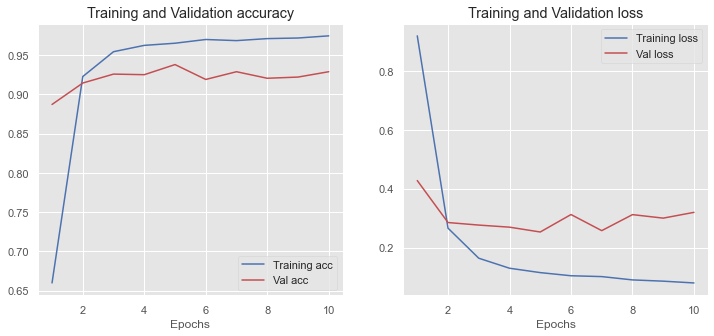

In [424]:
plot_history(history6)

In [425]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob5 = model6.predict(X_val_attract_w)
y_pred_class5 = np.argmax(model6.predict(X_val_attract_w), axis=-1)
y_val_attract_integer = np.argmax(y_val_attract_e, axis=1)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       240
           1       0.94      0.93      0.94       240
           2       0.96      0.89      0.93       120
           3       0.93      0.95      0.94       240
           4       0.95      0.99      0.97       160
           5       0.96      0.95      0.95       120
           6       0.90      0.91      0.90       200

    accuracy                           0.94      1320
   macro avg       0.94      0.94      0.94      1320
weighted avg       0.94      0.94      0.94      1320



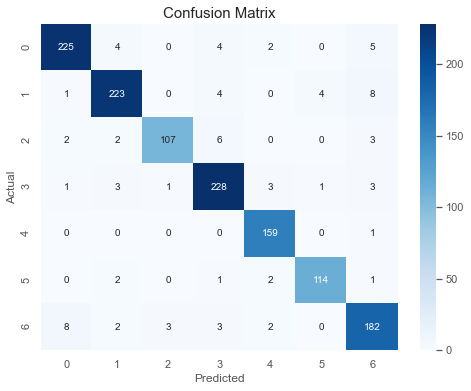

In [426]:
class_conf(y_val_attract_integer,y_pred_class5)

In [427]:
# Create dataframe with y pred probabilities, classes and y actual
attract_pred = pd.DataFrame(list(zip(y_val_attract_integer, y_val_attract,y_pred_class5)), columns=["Actual Class","Actual Aspect", "Predicted Class"])
attract_pred.head(10)

,Actual Class,Actual Aspect,Predicted Class
0,4,History,4
1,4,Value,4
2,3,Activities,3
3,0,History,0
4,6,Nature,6
5,3,VisitExp&Gen,6
6,0,Value,0
7,4,Nature,4
8,3,Nature,3
9,3,VisitExp&Gen,3


In [430]:
# Items not classified correctly
attract_pred[attract_pred["Actual Class"]!= attract_pred["Predicted Class"]].shape

(8, 3)

In [431]:
attract_pred.shape

(165, 3)

Comment:

* The data augmentation increased the results for the attractions model . 
* The spread of different words in the attractions model is likely contributing to the problems. There are so many different words being used in comparison to the 'food' model for example. More data helps the model classify better to a point.
* The same augmentation was applied to the accommodation category to see if this model could be improved with more data.

# Section 8: Applying data augmentation to accommodation and food models

## Accommodation model

In [432]:
# Look at value counts of classes in the attractions category
pd.Series(y_accom.value_counts())

Food             350
Entertainment    350
Room             350
Hotel            350
Staff            350
Value            250
Location         220
Name: Aspect, dtype: int64

In [433]:
def aug(X,y):
    # Concat and shuffle the data
    df_eda = pd.concat([X,y],axis = 1)
    df_eda = df_eda.sample(frac=1)
    
    # Random insertion
    df_insertion = pd.DataFrame(df_eda["Nouns"].apply(lambda x: t.random_insertion(x)))
    df_insertion = pd.concat([df_insertion,df_eda.Aspect],axis = 1)
    df_insertion = df_insertion.append(df_eda)
    
    # Random replacement 
    df_replaced = df_insertion["Nouns"].apply(lambda x: t.synonym_replacement(x))
    df_replaced = pd.concat([df_replaced,df_insertion.Aspect],axis = 1)
    df_replaced = df_replaced.append(df_insertion)
    
    # Random swap
    df_swapped = pd.DataFrame(df_replaced["Nouns"].apply(lambda x: t.random_swap(x,n  = 1)))
    df_swapped = pd.concat([df_swapped,df_replaced.Aspect],axis = 1)
    df_swapped = df_swapped.append(df_replaced)
    
    # Split into dataframes with one noun and more than one noun
    df_swapped["Count"] = df_swapped["Nouns"].apply(lambda x: len(x.split()))
    df_equal_one = df_swapped[df_swapped["Count"]==1].reset_index()
    df_more_one = df_swapped[df_swapped["Count"]>1].reset_index()
    
    # Apply to the dataset with at least one noun so we are not left with empty rows
    df_deleted = pd.DataFrame(df_more_one["Nouns"].apply(lambda x: t.random_deletion(x,p = 0.2)))
    df_deleted = pd.concat([df_deleted,df_more_one.Aspect],axis = 1,ignore_index=True)
    df_deleted.columns = ["Nouns","Aspect"]
    
    # Append the dataframe with deleted nouns to dataframe with single nouns
    df_equal_one.drop(columns = "Count",axis = 1, inplace = True)
    df_equal_one = df_equal_one.set_index("index")
    df_deleted = df_deleted.append(df_equal_one)
        
    return df_deleted

In [434]:
df_accom_augmented = aug(X_accom, y_accom)
df_accom_augmented.shape

(17760, 2)

In [435]:
y_train_accom_e, y_val_accom_e, y_test_accom_e, X_train_accom_w, X_val_accom_w, X_test_accom_w = tts(df_accom_augmented)

In [436]:
# Define model 

input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

model7 = Sequential()
model7.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model7.add(Flatten())
model7.add(Dense(512, activation='relu', input_shape=(1600,)))
model7.add(Dense(256,activation = 'relu'))
model7.add(Dense(128,activation = 'relu'))
model7.add(Dense(7, activation='softmax'))

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model7.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_12 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_49 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_50 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_51 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
_______________________________________________

In [437]:
output_dir = out('model_output/AccomAspectModels')
callbacks = call(output_dir,5)

In [438]:
# Model using keras embeddings using the previous model 4 but no class weights as the classes are balanced
history7= model7.fit(X_train_accom_w,y_train_accom_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_accom_w, y_val_accom_e),
                    batch_size=batch_size,
                      class_weight = class_weights
                     )

Epoch 1/50
888/888 - 1s - loss: 0.6480 - accuracy: 0.7886 - val_loss: 0.2590 - val_accuracy: 0.9330
Epoch 2/50
888/888 - 1s - loss: 0.2213 - accuracy: 0.9443 - val_loss: 0.1869 - val_accuracy: 0.9510
Epoch 3/50
888/888 - 1s - loss: 0.1702 - accuracy: 0.9593 - val_loss: 0.1933 - val_accuracy: 0.9431
Epoch 4/50
888/888 - 1s - loss: 0.1448 - accuracy: 0.9662 - val_loss: 0.1792 - val_accuracy: 0.9521
Epoch 5/50
888/888 - 1s - loss: 0.1241 - accuracy: 0.9698 - val_loss: 0.1747 - val_accuracy: 0.9521
Epoch 6/50
888/888 - 1s - loss: 0.1138 - accuracy: 0.9734 - val_loss: 0.1853 - val_accuracy: 0.9566
Epoch 7/50
888/888 - 1s - loss: 0.1035 - accuracy: 0.9751 - val_loss: 0.1818 - val_accuracy: 0.9493
Epoch 8/50
888/888 - 1s - loss: 0.0972 - accuracy: 0.9763 - val_loss: 0.1856 - val_accuracy: 0.9538
Epoch 9/50
888/888 - 1s - loss: 0.0931 - accuracy: 0.9766 - val_loss: 0.1824 - val_accuracy: 0.9578
Epoch 10/50
888/888 - 1s - loss: 0.0870 - accuracy: 0.9784 - val_loss: 0.2164 - val_accuracy: 0.9482

In [439]:
print(model7.evaluate(X_train_accom_w, y_train_accom_e))
print(model7.evaluate(X_val_accom_w, y_val_accom_e))

444/444 [==============================] - 0s 643us/step - loss: 0.0717 - accuracy: 0.9799
[0.07173813879489899, 0.9799408912658691]
56/56 [==============================] - 0s 659us/step - loss: 0.2164 - accuracy: 0.9482
[0.21639926731586456, 0.9481981992721558]


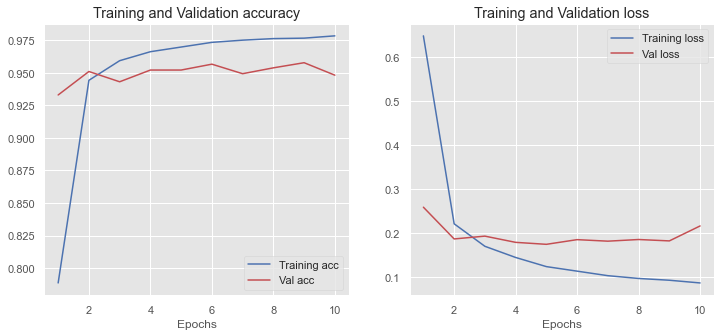

In [440]:
plot_history(history7)

In [442]:
# Load model weights from epoch with best validation accuracy
model6.load_weights(output_dir+"/weights.06.hdf5")

In [443]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob6 = model6.predict(X_val_accom_w)
y_pred_class6 = np.argmax(model7.predict(X_val_accom_w), axis=-1)
y_val_accom_integer = np.argmax(y_val_accom_e, axis=1)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       280
           1       0.97      0.94      0.95       280
           2       0.96      0.96      0.96       280
           3       0.92      0.97      0.95       176
           4       0.94      0.94      0.94       280
           5       0.98      0.94      0.96       280
           6       0.95      0.94      0.94       200

    accuracy                           0.95      1776
   macro avg       0.95      0.95      0.95      1776
weighted avg       0.95      0.95      0.95      1776



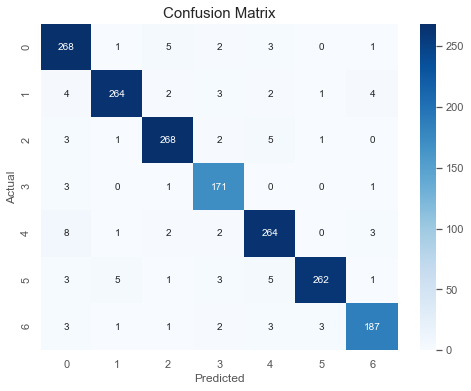

In [444]:
class_conf(y_val_accom_integer,y_pred_class6)

In [448]:
# Create dataframe with y pred probabilities, classes and y actual
accom_pred = pd.DataFrame(list(zip(y_val_accom_integer, y_val_accom,y_pred_class6)), columns=["Actual Class","Actual Aspect", "Predicted Class"])
accom_pred.head(10)

,Actual Class,Actual Aspect,Predicted Class
0,6,Food,6
1,4,Entertainment,4
2,6,Value,6
3,4,Location,4
4,4,Food,4
5,4,Staff,4
6,1,Food,1
7,1,Value,1
8,1,Location,1
9,1,Hotel,1


In [451]:
# Items not classified correctly
wrong_accom_aug = accom_pred[accom_pred["Actual Class"]!= accom_pred["Predicted Class"]]
wrong_accom_aug

,Actual Class,Actual Aspect,Predicted Class
26,4,Entertainment,0
47,4,Staff,0
96,2,Entertainment,4
102,6,Hotel,4
105,5,Hotel,2
143,1,Staff,0
147,4,Entertainment,2


In [452]:
print("The model predicted:", wrong_accom_aug.shape[0],"aspects wrong from a total of:",accom_pred.shape[0],"predictions")

The model predicted: 7 aspects wrong from a total of: 222 predictions


## Food model

In [481]:
# Balanced aspects
y_food_new.value_counts()

Staff&Service    350
Meal Exp         350
Food Quality     350
Value            350
Menu Choice      350
Name: Aspect, dtype: int64

In [482]:
df_food_augmented = aug(X_food_new, y_food_new)
df_food_augmented.shape

(14000, 2)

In [483]:
y_train_food_e, y_val_food_e, y_test_food_e, X_train_food_w, X_val_food_w, X_test_food_w = tts(df_food_augmented)

In [486]:
# Define model 

input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

model8 = Sequential()
model8.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model8.add(Flatten())
model8.add(Dense(512, activation='relu', input_shape=(1600,)))
model8.add(Dense(256,activation = 'relu'))
model8.add(Dense(128,activation = 'relu'))
model8.add(Dense(5, activation='softmax'))

model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model8.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_16 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_65 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 645       
Total params: 384,261
Trainable params: 384,261
Non-trainable params: 0
_______________________________________________

In [487]:
output_dir = out('model_output/FoodAspectModels')
callbacks = call(output_dir,5)

In [492]:
cw_food = weight(y_food_new)
class_weights = {0:cw_food[0],1:cw_food[1],2:cw_food[2],3:cw_food[3],4:cw_food[4]}
class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

In [493]:
# Model using keras embeddings using the previous model 4 but no class weights as the classes are balanced
history8= model8.fit(X_train_food_w,y_train_food_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_food_w, y_val_food_e),
                    batch_size=batch_size,
                      class_weight = class_weights
                     )

Epoch 1/50
700/700 - 1s - loss: 0.0860 - accuracy: 0.9742 - val_loss: 0.2050 - val_accuracy: 0.9621
Epoch 2/50
700/700 - 1s - loss: 0.0827 - accuracy: 0.9748 - val_loss: 0.2173 - val_accuracy: 0.9579
Epoch 3/50
700/700 - 1s - loss: 0.0819 - accuracy: 0.9742 - val_loss: 0.2279 - val_accuracy: 0.9543
Epoch 4/50
700/700 - 1s - loss: 0.0829 - accuracy: 0.9740 - val_loss: 0.2238 - val_accuracy: 0.9529
Epoch 5/50
700/700 - 1s - loss: 0.0784 - accuracy: 0.9754 - val_loss: 0.2147 - val_accuracy: 0.9571
Epoch 6/50
700/700 - 1s - loss: 0.0753 - accuracy: 0.9768 - val_loss: 0.2310 - val_accuracy: 0.9550


In [494]:
print(model8.evaluate(X_train_food_w, y_train_food_e))
print(model8.evaluate(X_val_food_w, y_val_food_e))

350/350 [==============================] - 0s 638us/step - loss: 0.0643 - accuracy: 0.9801
[0.06426393985748291, 0.9800893068313599]
44/44 [==============================] - 0s 431us/step - loss: 0.2310 - accuracy: 0.9550
[0.23104844987392426, 0.9549999833106995]


Analysis:
* The accommodation model has performed better with the augmented data but there are still some problems with the entertainment category in particular.
* Augmenting did improve both the accommodation and attraction models but further tweaking with parameters is only likely to improve the model by very small amounts. There appear to be some issues with some of the aspect classes and the ability of the model to discriminate between them. This may be due to the nature of the features which are often single words, with ambiguous meaning. 
* The food model was not improved

Possible improvements:
* Try multilabel classification as an alternative model, where rows can be labelled with multiple aspects, in particular the food category is likely to benefit from this as even at the noun phrase level, there are often multiple aspects.
* More data is often helpful, instead of augmenting data sets, larger labelled datasets would likely produce better quality training data. Paid services such as 'Mechanical Turk' can be useful if budget is available to do this. Labelling the data several times using different people produces a consensus which can be more accurate than just using one person to label.